In [41]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torchvision.datasets import EMNIST
from torchvision import transforms
from torch.utils.data import DataLoader, Subset
import random
import torch.nn.functional as F


# Neural Network Definition
class NeuralNet(nn.Module):
    def __init__(self):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(28*28, 128)
        self.fc2 = nn.Linear(128, 62)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)



In [42]:
from google.colab import drive
drive.mount('/content/drive')
path_to_data = 'drive/MyDrive/Colab Notebooks/train_data.npy'
user_ids = [0, 1, 2, 3, 4]  # Replace with chosen user IDs
datasets = np.load(path_to_data, allow_pickle=True)
#datasets = load_data(user_ids, path_to_data)
#train_on_clients(datasets)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [43]:

# Load and preprocess data
#transform = transforms.Compose([transforms.ToTensor()])
#dataset = EMNIST(root='./data', split='balanced', train=True, download=True, transform=transform)

# Simulate the distribution of data across clients
'''
def distribute_data(dataset, num_clients=100):
    client_data = []
    num_samples_per_client = len(dataset) // num_clients
    all_indices = list(range(len(dataset)))

    for i in range(num_clients):
        client_indices = random.sample(all_indices, num_samples_per_client)
        #all_indices = list(set(all_indices) - set(client_indices))
        client_data[i] = dataset[client_indices]

    return client_data

client_data = distribute_data(datasets)
'''



'\ndef distribute_data(dataset, num_clients=100):\n    client_data = []\n    num_samples_per_client = len(dataset) // num_clients\n    all_indices = list(range(len(dataset)))\n\n    for i in range(num_clients):\n        client_indices = random.sample(all_indices, num_samples_per_client)\n        #all_indices = list(set(all_indices) - set(client_indices))\n        client_data[i] = dataset[client_indices]\n\n    return client_data\n\nclient_data = distribute_data(datasets)\n'

In [44]:
# Training loop for each client
def train_client(model, client_dataset, epochs=5):
    model.train()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    #train_loader = DataLoader(client_data[client_id], batch_size=64, shuffle=True)
    tmp_accuracy = 0


    for epoch in range(epochs):
        images = torch.tensor(client_dataset['images'])
        labels = torch.tensor(client_dataset['labels']).type(torch.LongTensor)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        pred = torch.argmax(outputs,dim=1)
        tmp_accuracy += (pred == labels).float().sum()/(len(pred))

    return tmp_accuracy




In [45]:
# FedAvg Algorithm
def federated_averaging(global_model, client_models):
    global_dict = global_model.state_dict()

    for k in global_dict.keys():
        global_dict[k] = torch.stack([client_models[i].state_dict()[k].float() for i in client_models], 0).mean(0)

    global_model.load_state_dict(global_dict)
    for model in client_models.values():
        model.load_state_dict(global_model.state_dict())



In [46]:
#add_noise

def add_laplace_noise(data, scale, l):
    noise = np.random.laplace(0, scale,l)
    noisy_data = data + noise
    return noisy_data


noise_scale = 0.1  # Example scale, adjust as needed
for i in range(len(datasets)):
    l = len(datasets[i]['labels'])
    datasets[i]['labels'] = add_laplace_noise(datasets[i]['labels'], noise_scale, l)


In [50]:
# Main simulation
def run_simulation(client_data, num_rounds=200, num_clients=100, C=0.1, E=5):
    global_model = NeuralNet()
    client_models = {i: NeuralNet() for i in range(num_clients)}
    for i in range(num_clients):
        client_models[i].load_state_dict(global_model.state_dict())

    accuracy_list = []
    for round in range(num_rounds):
        selected_clients = random.sample(range(num_clients), int(num_clients * C))
        loss_list = []
        t = 0

        for client in selected_clients:
            client_dataset = datasets[client]
            #print(client_dataset)
            t += train_client(client_models[client], client_dataset, epochs=E)
        accuracy_list.append(t/len(datasets))

        federated_averaging(global_model, {client: client_models[client] for client in selected_clients})

    return accuracy_list
        # TODO: Evaluate global model on validation data and plot results

if __name__ == "__main__":
    acc = run_simulation(client_data)

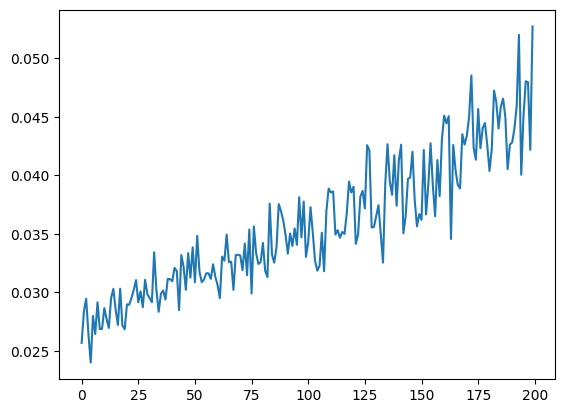

In [51]:
import matplotlib.pyplot as plt
import numpy as np

xpoints = np.arange(len(acc))

plt.plot(xpoints, [b_1.detach().numpy() for b_1 in acc])
plt.show()

In [52]:
#different noise levels


path_to_data = 'drive/MyDrive/Colab Notebooks/train_data.npy'
user_ids = [0, 1, 2, 3, 4]  # Replace with chosen user IDs
datasets = np.load(path_to_data, allow_pickle=True)
#add_noise

def add_laplace_noise(data, scale, l):
    noise = np.random.laplace(0, scale,l)
    noisy_data = data + noise
    return noisy_data

eval = {}
eval[str(0.1)] = acc[-1]

{'0.1': tensor(0.0527)}

In [54]:


noise_scale = 0.05 # Example scale, adjust as needed
for i in range(len(datasets)):
    l = len(datasets[i]['labels'])
    datasets[i]['labels'] = add_laplace_noise(datasets[i]['labels'], noise_scale, l)
# Main simulation
def run_simulation(client_data, num_rounds=200, num_clients=100, C=0.1, E=5):
    global_model = NeuralNet()
    client_models = {i: NeuralNet() for i in range(num_clients)}
    for i in range(num_clients):
        client_models[i].load_state_dict(global_model.state_dict())

    accuracy_list = []
    for round in range(num_rounds):
        selected_clients = random.sample(range(num_clients), int(num_clients * C))
        loss_list = []
        t = 0

        for client in selected_clients:
            client_dataset = datasets[client]
            #print(client_dataset)
            t += train_client(client_models[client], client_dataset, epochs=E)
        accuracy_list.append(t/len(datasets))

        federated_averaging(global_model, {client: client_models[client] for client in selected_clients})

    return accuracy_list
        # TODO: Evaluate global model on validation data and plot results

if __name__ == "__main__":
    acc_tmp = run_simulation(client_data)

    eval[str(noise_scale)] = acc_tmp[-1]



In [57]:
eval

{'0.1': tensor(0.0527), '0.05': tensor(0.0509)}

In [59]:
#different noise levels


path_to_data = 'drive/MyDrive/Colab Notebooks/train_data.npy'
user_ids = [0, 1, 2, 3, 4]  # Replace with chosen user IDs
datasets = np.load(path_to_data, allow_pickle=True)


noise_scale = 0.15 # Example scale, adjust as needed
for i in range(len(datasets)):
    l = len(datasets[i]['labels'])
    datasets[i]['labels'] = add_laplace_noise(datasets[i]['labels'], noise_scale, l)
# Main simulation
def run_simulation(client_data, num_rounds=200, num_clients=100, C=0.1, E=5):
    global_model = NeuralNet()
    client_models = {i: NeuralNet() for i in range(num_clients)}
    for i in range(num_clients):
        client_models[i].load_state_dict(global_model.state_dict())

    accuracy_list = []
    for round in range(num_rounds):
        selected_clients = random.sample(range(num_clients), int(num_clients * C))
        loss_list = []
        t = 0

        for client in selected_clients:
            client_dataset = datasets[client]
            #print(client_dataset)
            t += train_client(client_models[client], client_dataset, epochs=E)
        accuracy_list.append(t/len(datasets))

        federated_averaging(global_model, {client: client_models[client] for client in selected_clients})

    return accuracy_list
        # TODO: Evaluate global model on validation data and plot results

if __name__ == "__main__":
    acc_tmp = run_simulation(client_data)

    eval[str(noise_scale)] = acc_tmp[-1]






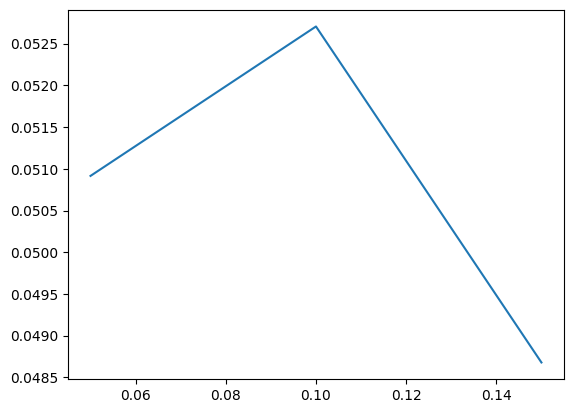

In [74]:
import matplotlib.pyplot as plt
import numpy as np

xpoints = np.sort([float(x) for x in list(eval.keys())])
ypoints = [eval[str(x)] for x in xpoints]


plt.plot(xpoints, ypoints)
plt.show()